In [126]:
import lzma
import pickle

import numpy as np
import pandas as pd
from sklearn import linear_model

In [127]:
from ares import ALL_STRUCTURES
from sc2.dicts.unit_trained_from import UNIT_TRAINED_FROM

unit_types = ALL_STRUCTURES | UNIT_TRAINED_FROM.keys()
unit_type_values = {u.value for u in unit_types}

In [129]:
df_train = pd.read_parquet("../resources/datasets/scout/train.parquet")
df_test = pd.read_parquet("../resources/datasets/scout/test.parquet")

In [130]:
from itertools import product


def to_numpy(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    df = df.reset_index()
    df = df.assign(is_own=df["owner"] == df["player"])
    df = df.pivot_table(
        index=["replay_name", "game_loop", "player"],
        columns=["is_own", "unit_type"],
        values="count",
    )
    df = df.reindex(columns=[(o, t) for o, t in product([False, True], unit_type_values)])
    df = df.fillna(0)
    df = df.astype(int)
    df = df.reset_index()
    df = df.drop(["replay_name", "player"], axis=1, level=0)

    x = df.to_numpy()
    y = np.hstack([x[1::2, :], x[::2, :]]).reshape(x.shape)

    return x, y

In [139]:
df_train.dtypes

index                   int64
game_loop               int32
unit_type               int32
player                   int8
owner                    int8
count                   int64
replay_name    string[python]
dtype: object

In [132]:
x_train, y_train = to_numpy(df_train)
x_test, y_test = to_numpy(df_test)

In [133]:
model = linear_model.LinearRegression()
model.fit(x_train, y_train)
model.coef_

array([[ 1.00000000e+00, -9.18017212e-14, -4.80783638e-12, ...,
        -4.80431399e-14,  0.00000000e+00,  0.00000000e+00],
       [ 1.28160699e-06, -1.52138044e-02, -3.05053387e-03, ...,
        -6.63760283e-04,  0.00000000e+00,  0.00000000e+00],
       [-1.64596669e-08, -1.50850578e-05, -7.16929469e-05, ...,
         1.36251869e-05,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.26013437e-05,  4.14367111e-03, -1.90535202e-02, ...,
        -9.69774860e-03,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
      shape=(273, 273))

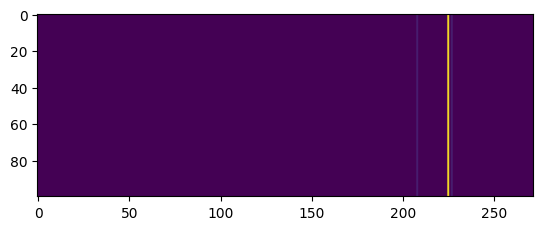

In [134]:
import matplotlib.pyplot as plt

plt.imshow(x_test[:100, 1:])

In [135]:
y_pred = model.predict(x_test)
y_pred

array([[-3.10861852e-11,  6.15887754e-03,  8.81983704e-04, ...,
         1.09593393e-01,  0.00000000e+00,  0.00000000e+00],
       [-3.10861852e-11,  6.15887754e-03,  8.81983704e-04, ...,
         1.09593393e-01,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  6.16015915e-03,  8.81967244e-04, ...,
         1.09580792e-01,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 2.08640000e+04,  5.71089869e-01,  2.12107340e-04, ...,
         1.32837369e-01,  0.00000000e+00,  0.00000000e+00],
       [ 2.08650000e+04,  4.64789213e-02,  6.47797072e-04, ...,
        -1.36297296e-01,  0.00000000e+00,  0.00000000e+00],
       [ 2.08650000e+04,  5.72870808e-01,  3.78059110e-04, ...,
         1.32226110e-01,  0.00000000e+00,  0.00000000e+00]],
      shape=(72000, 273))

In [136]:
y_test - y_pred

array([[ 3.10861852e-11, -6.15887754e-03, -8.81983704e-04, ...,
        -1.09593393e-01,  0.00000000e+00,  0.00000000e+00],
       [ 3.10861852e-11, -6.15887754e-03, -8.81983704e-04, ...,
        -1.09593393e-01,  0.00000000e+00,  0.00000000e+00],
       [ 3.10834691e-11, -6.16015915e-03, -8.81967244e-04, ...,
        -1.09580792e-01,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.18278728e-11,  4.28910131e-01, -2.12107340e-04, ...,
        -1.32837369e-01,  0.00000000e+00,  0.00000000e+00],
       [-2.18278728e-11, -4.64789213e-02, -6.47797072e-04, ...,
         1.36297296e-01,  0.00000000e+00,  0.00000000e+00],
       [-2.18278728e-11,  4.27129192e-01, -3.78059110e-04, ...,
        -1.32226110e-01,  0.00000000e+00,  0.00000000e+00]],
      shape=(72000, 273))

In [143]:
np.quantile(np.abs(y_test - y_pred), 0.99)

np.float64(9.342627704581393)

In [138]:
with lzma.open("../resources/models/scout.pkl.xz", "wb") as f:
    pickle.dump(model, f)